# 1. Timeseries analysis using autoregressive methods and general Box-Jenkins methods

Some useful translations, just in case:

- **a timeseries**: une série temporelle (always plural in English)
- **a trend**: une tendance
- **a lag**: un retard, un décalage dans le temps
- **stationary**: stationnaire


Some interesting content to dive deeper and/or go further about timeseries analysis, or that might help you during the TD:

- [The engineering statistics handbook on timeseries analysis](https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc4.htm)

- [A Stanford class on autoregressive models seen as generative models](https://deepgenerativemodels.github.io/notes/) (and more on deep generative models)

In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels
import scipy

## 1. Analysis

For this exercise, we will use a timeseries representing daily average temperature in Melbourne, Australia between 1980 and 1990.

This timeseries will be stored in a [Pandas DataFrame object](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html), a standard to handle tabular data in Python.

This analysis will follow the steps proposed by George Box and Gwilym Jenkins in 1970, called [Box-Jenkins method](https://en.wikipedia.org/wiki/Box%E2%80%93Jenkins_method), which emphasizes issues encountered when appliying autoregressive methods.

In [18]:
# Read data from remote repository
raw_df = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv", index_col=0)

In [19]:
# Display the 5 first data points
raw_df.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


Data is divided in two for model evaluation. We will use 8 first years as training data, and the two remaining years as test data.

In [20]:
df, test_df = raw_df.iloc[:8*365], raw_df.iloc[8*365:]

### 1.1 Run-plots analysis

"Run-plots" are the simplest representation of a timeseries, where the x-axis represents time and the y-axis represents the observed variable, here temperature in Celsius degrees.


**Question: Given the figures and the statistic test below, what hypothesis can you draw regarding the behaviour of this timeseries? Is is stationary? Does it displays seasonality? Trending? Explain. You can create additional figures if you need.**

***(You answer here)***

<Axes: title={'center': 'Temperature in Melbourne - 1980 to 1990'}, xlabel='Date'>

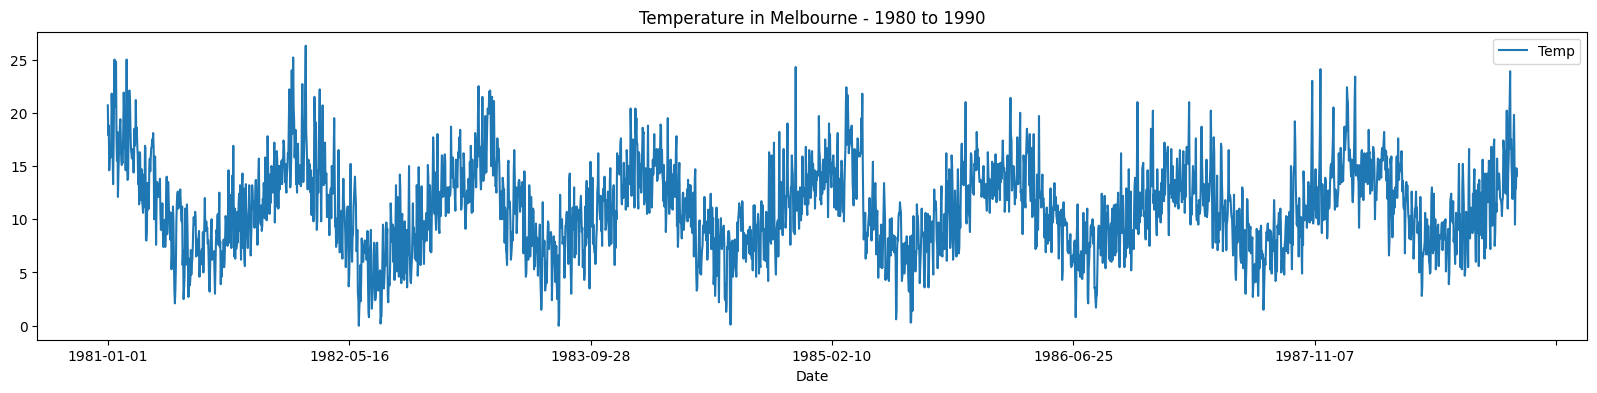

In [21]:
# Plot the full timeseries
df.plot(figsize=(20, 4), title="Temperature in Melbourne - 1980 to 1990")

<Axes: title={'center': 'Temperature in Melbourne - one year'}, xlabel='Date'>

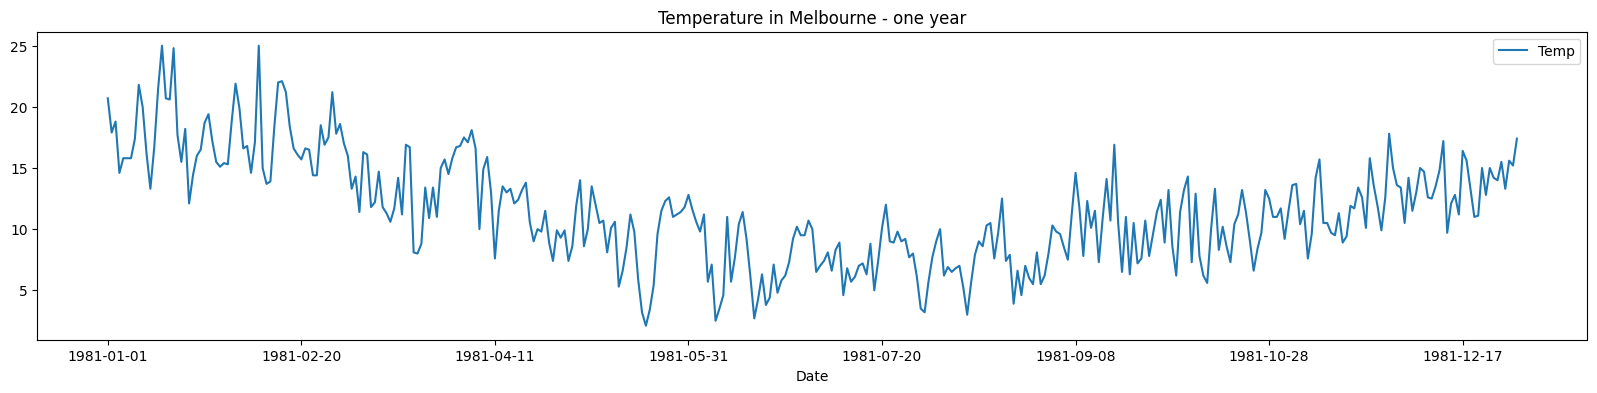

In [22]:
# Plot the first year of data
df.iloc[:365].plot(figsize=(20, 4), title="Temperature in Melbourne - one year")

The Kwiatkowski-Phillips-Schmidt-Shin test is a statistical test used to check
the stationarity of a timeseries. It is implemented in the `kpss()` function in `statsmodels`.

In [23]:
from statsmodels.tsa.stattools import kpss

kpss_stat, p, *other_stuff = kpss(df)

print(f"p-value (95% confidence interval): {p:g}, statistics: {kpss_stat:g}")

p-value (95% confidence interval): 0.1, statistics: 0.0692855


/tmp/ipykernel_3322/2308919192.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, p, *other_stuff = kpss(df)


***(Draw your conclusions here)***

Do we need to differentiate ? If yes, try to apply the difference operator on your data.

In [1]:
# df.diff() ?

---
We will now compute autocorrelation function (ACF) and partial autocorrelation function (PACF) of the timeseries. These functions compute correlation (or partial correlation) between $X[t]$ and $X[t-n]$, for an interval of different lags $n$. For now, we only evaluated correlation for lag $n=1$.

**Question: Plot the ACF and the PACF of the timeseries, with $n={1, \dots, 31}$ (one month lag) and $n={1, \dots, 730}$ (2 years lag). What is your hypothesis on the lag to use to create the model ?**


*Some help:*

- See documentation of `statsmodels.graphics.tsaplots.plot_acf` to understand how to change the number of lags to plot.

- **Autocorrelation** is the result of the multiplication (or convolution) of all points of the signal with themselves, shifted in time by a lag of $n$. The **autocorrelation function** (ACF) is the function giving autocorrelation for any lag $n$.

- **Partial autocorrelation** is similar to autocorrelation, but the correlation between two points of the signal is computed assuming that this two points are independent from all points between them in time.  The **partial autocorrelation function** (PACF) is the function giving partial autocorrelation for any lag $n$.

- Autocorrelation is helpful to check if a process in autoregressive. **Autoregressive processes are auto-correlated**.

- Partial autocorrelation is helpful to find the order of an autoregressive process, i.e. **how many past steps are needed to predict the future one**.

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

#### 1.2.1 Autocorrelation

In [ ]:
# Plot autocorrelation for lags between 1 and 730 days
...

plt.show()

In [ ]:
# Plot autocorrelation for lags between 1 and 31 days
...

plt.show()

#### 1.2.2 Partial autocorrelation

In [ ]:
# Plot partial autocorrelation for lags between 1 and 730 days
...

plt.show()

In [ ]:
# Plot partial autocorrelation for lags between 1 and 31 days
...

plt.show()

***(Your hypothesis here)***

## 2. Modeling

### 2.1 Modeling : ARIMA


In [114]:
from statsmodels.tsa.arima.model import ARIMA

ARIMA is an acronym that stands for AutoRegressive Integrated Moving Average, capturing the key aspects of the model :

- **AR** : *AutoRegressive* A model that uses the dependent relationship between an observation and some number of lagged observations.
A pure AR model is such that :
$$
Y_t = \alpha + \beta_1 Y_{t-1} + \beta_2 Y_{t-2} + ... + \beta_{p} Y_{t-p} + \epsilon_1
$$
- **I** : *Integrated* The use of differencing of raw observations in order to make the time series stationary
- **MA** : *Moving Average* A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations
A pure moving average model is such that :
$$
Y_t = \alpha + \epsilon_t + \phi_1 \epsilon_{t-1} + \phi_2 \epsilon_{t-2} + ... + \phi_q \epsilon_{t-q}
$$


Thus finally, the equation for ARIMA becomes :
$$
Y_t = \alpha + \beta_1 Y_{t-1} + ... + \beta_p Y_{t-p} \epsilon_t + \phi_1 \epsilon_{t-1} + ... + \phi_q \epsilon_{t-q} 
$$

Each of these components is specified in the model as a parameter :
- **p** : number of lag observations
- **d** : number of times that raw observations are differenced. 
It is the minimum number of differencing needed to make the series stationary. If the time series is already stationary, then d= 0
- **q** : size of moving average window

Now, we will fit an ARIMA forecast model to the daily minimum temperature data.
Note that the data contains a one-year seasonal component. We will ignore it for now, **but a SARIMA model could be used instead.**


In [89]:
# Create an ARIMA model (check the statsmodels docs)
model = ...

# fit model
model_fit = model.fit()
print(model_fit.summary())

/home/nathan/Projects/handwritten-sandbox/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/nathan/Projects/handwritten-sandbox/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/nathan/Projects/handwritten-sandbox/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/nathan/Projects/handwritten-sandbox/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invert

                               SARIMAX Results                                
Dep. Variable:                   Temp   No. Observations:                 2920
Model:                 ARIMA(7, 2, 7)   Log Likelihood               -6768.902
Date:                Tue, 26 Sep 2023   AIC                          13567.804
Time:                        23:48:18   BIC                          13657.484
Sample:                             0   HQIC                         13600.107
                               - 2920                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.0988      0.445     -4.716      0.000      -2.971      -1.226
ar.L2         -2.6349      0.630     -4.181      0.000      -3.870      -1.400
ar.L3         -2.0398      0.625     -3.262      0.0

/home/nathan/Projects/handwritten-sandbox/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


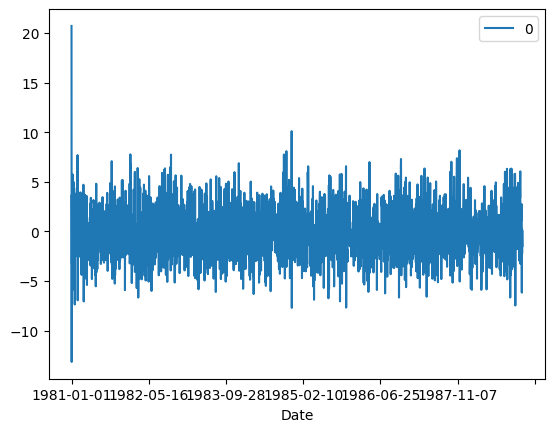

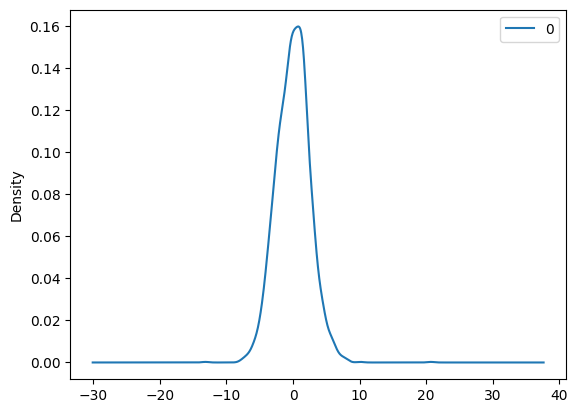

Residuals stats:                  0
count  2920.000000
mean      0.016523
std       2.503844
min     -13.150001
25%      -1.682538
50%       0.071117
75%       1.630322
max      20.700000


In [90]:
# reviewing the residual errors
# line plot
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot
residuals.plot(kind='kde')
plt.show()
# summary stats
print("Residuals stats:", residuals.describe())

Now, evaluate your model on the training set `test_df`. Use a regression metric to compute a score (mean square error for instance).

Try small: forecast the next 50 days.

What happens if you try to forecast a long period of time?

In [112]:
from math import sqrt
from sklearn.metrics import mean_squared_error


# Make forecast for 50 days and compute score
# (hint: see the forecast() function of the ARIMA model)
y_pred = ...

/home/nathan/Projects/handwritten-sandbox/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/nathan/Projects/handwritten-sandbox/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


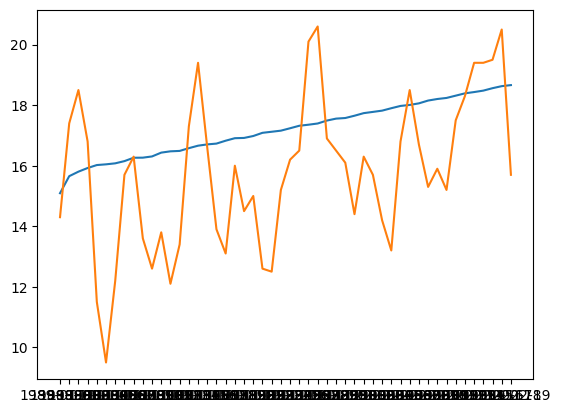

In [113]:
# Plot forecasts
plt.plot(y_pred.values)
plt.plot(test_df.iloc[:50])
plt.show()

## Exercise: Mauna Loa CO<sub>2</sub> concentration levels (1975 - 2021)


Carbon dioxyde (CO<sub>2</sub>) is a gas naturaly present in our environment. However, the concentration of CO<sub>2</sub> is increasing every year, mainly because of human activities. It is one of the major cause of global warming, and its value is precautiounously measured since 1973 at the Mauna Loa observatory, in Hawaii.

We will get interested on the measures performed between 1975 and 2021. The dataset is composed of monthly averaged values. Values are expressed in *ppm* (parts-per-million).

**Question: Appliying the method described above, model the behaviour of this timeseries.**

**Question: Using your model, make some short term predictions after 2001, and evaluate your model.**

*Some help*

- Be careful ! This timeseries is more difficult to model (do not forget the stationarity property...)
- If a timeseries is not stationary, one can **differenciate** its values over time to create a stationary approximation of the timeseries (like ARIMA does). You can also **remove the linear trend** from the data. Differencing (for an order 1 differenciation) implies transforming $X[t]$ into $X[t] - X[t-1]$.
- Maybe a seasonal model (SARIMA, ...) could be interesting ?
- You can do projections by using the model as a **generative model**: using the predicted value $X[t]$, you can predict $X[t+1$] using $X[t]$, then predict $X[t+2]$ using $X[t+1]$ and so on, using only the predictions of your model. For instance, with a dataset stopping in December 2021, you can predict January 2022 using December 2021, which you know from the dataset. Then, you can predict February 2022 from January 2022, March 2022 from February 2022...

*Reference:*

K.W. Thoning, A.M. Crotwell, and J.W. Mund (2021), Atmospheric Carbon Dioxide Dry Air Mole Fractions from continuous measurements at Mauna Loa, Hawaii, Barrow, Alaska, American Samoa and South Pole. 1973-2020, Version 2021-08-09 National Oceanic and Atmospheric Administration (NOAA), Global Monitoring Laboratory (GML), Boulder, Colorado, USA

In [141]:
ts = pd.read_csv("https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_mm_mlo.csv", header=39)

ts = ts[ts["year"] > 1975]
ts["day"] = 1

time_index = pd.DatetimeIndex(pd.to_datetime(ts[["year", "month", "day"]]))
ts = ts.set_index(time_index)
ts = pd.Series(ts["average"])

Train dataset ends at January 1st 2000. 

In [142]:
test_begin = datetime.datetime(2000, 1, 1)
ts_train = ts.loc[:test_begin]
ts_test = ts.loc[test_begin:]

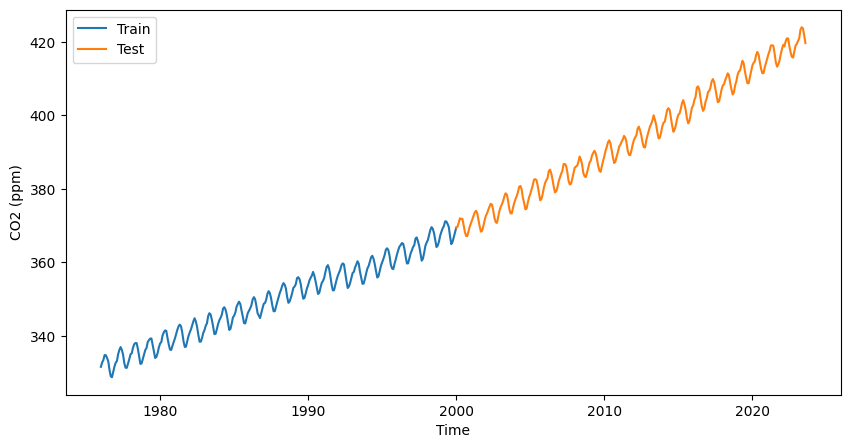

In [143]:
plt.figure(figsize=(10, 5))
plt.plot(ts_train, label="Train")
plt.plot(ts_test, label="Test")
plt.legend()
plt.xlabel("Time")
plt.ylabel("CO2 (ppm)")
plt.show()

### Identification


1. Analyse the timeseries, look for **trend**, **seasonality**, **stationarity**, and any other remarkable cues.

2. Is the timeseries stationary ? If not, what to do ?

Tools: 

    statsmodels.tsa.seasonal.seasonal_decompose
    statsmodels.tsa.stattools.adfuller
    statsmodels.tsa.stattools.kpss
    pandas (.diff())
    matplotlib

3. What about autocorrelation ? What kind of model am I looking for ?

4. What hyperparameters can I select ? (precise values or ranges)

Tools: 

    statsmodels.graphics.tsaplots.plot_acf
    statsmodels.graphics.tsaplots.plot_pacf

## Estimation

1. (Optional, if you have time) Choose a training procedure to test all hyperparameters combinations in a robust way (cross-validation, walk-forward, etc.)

2. Choose metrics to record during estimation. Compute statistics over different cross-validation folds/train dataset lengths to assess the robustness of your model.

3. Create a training loop for the model you chose, visualize metrics afterwards (predictions, metrics over hyperparameter/time/fold, Q-Q plots for residuals...)

4. Select the best model(s).

Tools:

    statsmodels.tsa.arima.model.ARIMA
    sklearn.metrics

### Evaluation

1. Forecast on the test set.

2. Forecast the future (with confidence interval if possible).


### More insights: AR from scratch (just as an example, nothing to do here)

AR stands for AutoRegressive. Autoregressive models describe the value of any points in a timeseries given the values of $p$ previous points, establishing a linear relashionship between them such that:

$$
X_t = \alpha + \beta_1 X_{t-1} + \beta_2 X_{t-2} + ... + \beta_{p} X_{t-p} + \epsilon_t
$$

where $X$ is a timeseries, $p$ is the lag used in the AR model, also called the **order** of the model, and $\beta=\{\beta, \dots, \beta_p\}$ and $\alpha$ are the parameters we want to estimate. $\epsilon_t$ is a white noise random process that we will consider to be 0 for all time steps in our model.

$X_t$ is therefore linearly dependent from its $p$ previous values $X_{t-1}, \dots, X_{t-p}$. We can learn $\beta_{[1, p]}$ and $\alpha$ using a linear regression defined by:

$$
[\alpha, \beta_{[1, p]}] = X \cdot X_{lags}^\intercal \cdot (X_{lags} \cdot X_{lags}^\intercal)^{-1}
$$

where $X$ is the whole timeseries with an available lag ($t-p$ timesteps have $p$ past values, the $p$ first timesteps do not have pasts values), and $X_{lags}$ are the $X_{t-1}, \dots, X_{t-p}$ for all time steps with an available lag $t-p$.

In [ ]:
# We store all values of the series in a numpy array called series
series = df["Temp"].values

In [ ]:
def auto_regression(series, order):
    
    n_points = len(series)

    # All lagged values will be stored in y_lag.
    # If order is 7, for each timestep we will store 7 values.
    X_lag = np.zeros((order, n_points-order))

    # All current values will be stores in X.
    X = np.zeros((1, n_points-order))
    for i in range(0, n_points-order-1):
        X_lag[:, i] = series[i:i+order]  # get the lagged values
        X[:, i] = series[i+order+1]  # get the current value

    # Add a constant term (c=1) to X_lag to compute alpha in the linear
    # regression
    X_lag = np.vstack((np.ones((1, n_points-order)), X_lag))

    # Linear regression
    coef = np.dot(np.dot(X, X_lag.T), scipy.linalg.pinv(np.dot(X_lag, X_lag.T)))
    
    alpha = coef[:, 0]
    beta = coef[:, 1:]

    return alpha, beta

In [ ]:
alpha, beta = auto_regression(series, order=9)

Now that we have our coefficients learned, we can make predictions.

In [ ]:
lag = beta.shape[1]

Y_truth = []  # real timeseries
Y_pred = []   # predictions
for i in range(0, len(series)-lag-1):
    # apply the equation of AR using the coefficients at each time steps
    y = alpha + np.dot(beta, series[i:i+lag]) # y[t] = alpha + y[t-1]*beta1 + y[t-2]*beta2 + ...

    Y_pred.append(y)
    Y_truth.append(series[i+lag+1])

Y_pred = np.array(Y_pred).flatten()
Y_truth = np.array(Y_truth).flatten()

In [ ]:
# Plot the results for one year
plt.plot(series[lag+1:lag+366], label="True series")
plt.plot(Y_pred[:365], label="Predicted values")
plt.legend()
plt.show()

And here are our coefficients:

In [ ]:
coefs = np.c_[alpha, beta]
plt.bar(np.arange(coefs.shape[1]), coefs.flatten())
labels = ['$\\alpha$']
for i in range(beta.shape[1]):
    labels.append(f"$\\beta_{i+1}$")

plt.xticks(np.arange(coefs.shape[1]), labels)
plt.show()